# NBA Success for Draft Prospects: Research and Extension

## Data Processing
We will combine player information and NBA Combine statistics from this dataset (https://www.kaggle.com/datasets/wyattowalsh/basketball/data) with the Win Shares data from this dataset (https://www.kaggle.com/datasets/robertsunderhaft/nba-player-season-statistics-with-mvp-win-share/data). We will be using NBA Combine (solely, without the inclusion of college basketball performance data, as is explained in the "Random Forest with LOOCV" section) data to predict Win Shares, as was done in the papers that we researched.

In [2]:
import pandas as pd

# Player info, draft combine stats, and win shares data
player_df = pd.read_csv('Data/common_player_info.csv')
draft_df = pd.read_csv('Data/draft_combine_stats.csv')
ws_df = pd.read_csv('Data/NBA_Dataset.csv')

# Dropping irrelevant columns
# print("Player DataFrame:")
# print(player_df.head())
player_df = player_df.drop(player_df.columns[10:29].tolist() + [player_df.columns[7], player_df.columns[32]], axis=1)
# print("Player DataFrame:")
# print(player_df.head())
# print("\nDraft DataFrame:")
# print(draft_df.head())
draft_df = draft_df.drop(draft_df.columns[24:47].tolist() + [draft_df.columns[8], draft_df.columns[9], draft_df.columns[16], draft_df.columns[17], draft_df.columns[21]], axis=1)
# print("\nDraft DataFrame:")
# print(draft_df.head())
# print("\nWS DataFrame:")
# print(ws_df.head())

# Computing the average win share for a player's career, since they were broken up by season
average_ws = ws_df.groupby('player')['ws'].mean()
average_ws_df = average_ws.reset_index()
average_ws_df.columns = ['Player', 'Average WS']
# print(average_ws_df)

# Merging all of the datasets
merge_1 = pd.merge(player_df, draft_df, left_on='display_first_last', right_on='player_name', how='inner')
# print("\nMerge 1:")
# merge_1.head()
merge_2 = pd.merge(merge_1, average_ws_df, left_on='display_first_last', right_on='Player', how='inner')
# print("\nMerge 2:")
# print(merge_2.head())

# Immputing NaN values and removing rows with NaN values in non-integer columns (only 17 records removed)
# nan_count = merge_2.isna().any(axis=1).sum()
# print(f"Number of rows containing at least one NaN: {nan_count}")
merge_2.fillna(merge_2.mean(numeric_only=True), inplace=True)
# nan_count = merge_2.isna().any(axis=1).sum()
# print(f"Number of rows containing at least one NaN: {nan_count}")
merge_2.dropna(inplace=True)

# Dropping duplicate columns, such as name
# print(merge_2.columns)
merge_2 = merge_2.drop(merge_2.columns[[0, 1, 2, 4, 5, 6, 12, 13, 14, 15, 16, 31]], axis=1)
merge_2.rename(columns={'Average WS' : 'avg_ws'}, inplace=True)
# merge_2.head()
final_df = merge_2

# At this point, final_df has all the data that we will use for the model. Goal is to predict 'avg_ws' using everything except 'name', 'draft_year', 'draft_round', and 'draft_number'
# some of the columns are duplicate data, just different units of measurement. we will only use the columns with a single unit of measurement
features = ['avg_ws', 'school', 'country', 'position', 'height_wo_shoes', 'weight', 'wingspan', 'standing_reach', 'body_fat_pct', 'standing_vertical_leap', 'max_vertical_leap', 'lane_agility_time', 'three_quarter_sprint', 'bench_press']
data = final_df[features].copy()
# class label is 'avg_ws'
X = data.drop('avg_ws', axis=1)
y = data['avg_ws']

In the above cell, we are processing our data to get it ready to train on. We are first merging two datasets, one containing NBA combine data and the other containing win share data. We use player names to merge the data. We removed redundant features, such as first name/last name columns, and removed records with NaN values for qualitative features, which only removed 17 total records. We imputed NaN values with the average of that column. Win share data was originally broken down by player *and* season, so we calculated the average win shares per season for each player and added this as a feature to our dataset.

## Linear Regression

4.021977822856798
-0.011124270365519884


Text(0, 0.5, 'Predicted')

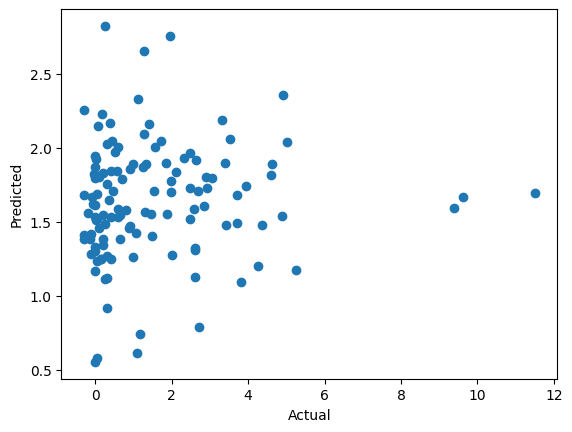

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# drop non-numeric columns for linear regression
X = X.drop(['school', 'country', 'position'], axis=1)
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

For the linear regression model, we dropped all categorical columns and only used numerical data. I would expect this model to be the worst-performing one, partially because it uses the least amount of data, but also because many combine traits don't scale linearly with in-game performance. The r2 score is -0.01, which means we would have been better off guessing the average. The third paper had similar findings, in that an NBA players win-shares combine performance is relatively uncorrelated in a linear regression model. In accordance with the findings in the third paper, we believe that different models would better suit our dataset.

## Multi-class SVM

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# 2-class SVM
X = data.drop('avg_ws', axis=1)
y = data['avg_ws']

# create binary groups at bottom 80 percentile and top 20 percentile for the 2-class SVM
y = pd.qcut(y, q=[0, 0.8, 1.0], labels=[0, 1])

# define the categorical columns
cat_cols = ['school', 'country', 'position']

# apply one-hot encoding to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

# Create a pipeline to preprocess the data and train the SVM
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),
        ('svm', SVC(kernel='linear', C=1.0, random_state=420))
    ]
)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

# train the pipeline
pipeline.fit(X_train, y_train)

# predict the classes for the test set
y_pred = pipeline.predict(X_test)

accuracy = pipeline.score(X_test, y_test)
print("2-class accuracy:", accuracy)
print("2-class MSE: ", mean_squared_error(y_test, y_pred))


# =========================================================
# 3-class SVM
X = data.drop('avg_ws', axis=1)
y = data['avg_ws']

y = pd.qcut(y, q=[0, 0.5, 0.9, 1.0], labels=[0, 1, 2])

cat_cols = ['school', 'country', 'position']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),
        ('svm', SVC(kernel='linear', C=1.0, decision_function_shape='ovr', random_state=420))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = pipeline.score(X_test, y_test)
print("3-class accuracy:", accuracy)
print("3-class MSE: ", mean_squared_error(y_test, y_pred))


# =========================================================
# 5-class SVM
X = data.drop('avg_ws', axis=1)
y = data['avg_ws']

y = pd.qcut(y, q=[0, 0.5, 0.8, 0.9, 0.99, 1.0], labels=[0, 1, 2, 3, 4])

cat_cols = ['school', 'country', 'position']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),
        ('svm', SVC(kernel='linear', C=1.0, decision_function_shape='ovr', random_state=420))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = pipeline.score(X_test, y_test)
print("5-class accuracy:", accuracy)
print("5-class MSE: ", mean_squared_error(y_test, y_pred))

2-class accuracy: 0.7786885245901639
2-class MSE:  0.22131147540983606
3-class accuracy: 0.4344262295081967
3-class MSE:  0.8852459016393442
5-class accuracy: 0.4262295081967213
5-class MSE:  1.7950819672131149


In the multi-class SVM models, we decided to take a slightly different approach than that of the third paper, which used 2, 3, and 5-class SVM models. Here, we classified players by their win share percentiles. In the 2-class SVM, we split players into the top 20% of players (generally the starters) and the bottom 80% (non-starters). Here, we got an accuracy of around 78% with an MSE of 0.221. In the 3-class SVM, we split players into the bottom 50% (non-contributors), the next 40% (contributing players) and the top 10% (all-star level players). This gave us an accuracy of about 43% with an MSE of 0.885. Our classification breakdowns were inspired from the second paper, where the authors attempted to classify players as MVP candidates, All-Stars, starters, bench players, or non-contributing players, which we used distinctly for the 5-class SVM. The percentile cuts were the bottom 50%, the next 80%, the next 10%, the next 9%, and finally the top 1%, going from non-contributing players to all-star players. Our results performed better than simple guessing, as did those in the paper. The results in the paper were slightly better than ours for each classification breakdown; we feel that this is because the paper included college basketball performance data for each player, which, considering the impact that college performance *should* have on NBA peformance and SVM models' success in high-dimensional spaces, could explain the difference in accuracy. Additionally, considering the strong correlation between many NBA Draft measureables, we felt that combining PCA with our SVM could improve our results, which we (and the authors of the paper) explore in a following section.

## Multi-class SVM with PCA

In [125]:
# 2-class SVM
X = data.drop('avg_ws', axis=1)
y = data['avg_ws']

y = pd.qcut(y, q=[0, 0.8, 1.0], labels=[0, 1])

cat_cols = ['school', 'country', 'position']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),
        ('pca', PCA(n_components=10, svd_solver='arpack')),
        ('svm', SVC(kernel='linear', C=1.0, decision_function_shape='ovr', random_state=420))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = pipeline.score(X_test, y_test)
print("2-class accuracy:", accuracy)
print("2-class MSE: ", mean_squared_error(y_test, y_pred))

# =========================================================
# 3-class SVM
X = data.drop('avg_ws', axis=1)
y = data['avg_ws']

y = pd.qcut(y, q=[0, 0.5, 0.9, 1.0], labels=[0, 1, 2])

cat_cols = ['school', 'country', 'position']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),
        ('pca', PCA(n_components=10, svd_solver='arpack')),
        ('svm', SVC(kernel='linear', C=1.0, decision_function_shape='ovr', random_state=420))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = pipeline.score(X_test, y_test)
print("3-class accuracy:", accuracy)
print("3-class MSE: ", mean_squared_error(y_test, y_pred))

# =========================================================
# 5-class SVM
X = data.drop('avg_ws', axis=1)
y = data['avg_ws']

y = pd.qcut(y, q=[0, 0.5, 0.8, 0.9, 0.99, 1.0], labels=[0, 1, 2, 3, 4])

cat_cols = ['school', 'country', 'position']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),
        ('pca', PCA(n_components=10, svd_solver='arpack')),
        ('svm', SVC(kernel='linear', C=1.0, decision_function_shape='ovr', random_state=420))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = pipeline.score(X_test, y_test)
print("5-class accuracy:", accuracy)
print("5-class MSE: ", mean_squared_error(y_test, y_pred))

2-class accuracy: 0.819672131147541
2-class MSE:  0.18032786885245902
3-class accuracy: 0.5409836065573771
3-class MSE:  0.6311475409836066
5-class accuracy: 0.5245901639344263
5-class MSE:  1.5


Here we used the same strategy as before, but instead this time performing PCA. We thoroughly tested the number of components that would yield us the optimal results in our testing. We found n_components to be optimal at n=10. Here, our results are slightly better than without PCA, and and better than random guessing. Our 2-class accuracy was about 82% with an MSE of 0.180, our 3-class accuracy was about 54% with an MSE of 0.631, and our 5-class accuracy was about 52% with an MSE of 1.5. This is opposite to the results we found in the second paper, which found that PCA made their results slightly worse, and not using PCA was slightly better than random guessing. We do think they did perform slightly better than us on average, and again, we believe this is due to their inclusion of player data at the collegiate level, and not just NBA Combine data. Because our data was at a lower dimensionality than the paper's to begin with, PCA gave us the extra dimensionality the SVM needed to improve its accuracy.

## Random Forest with LOOCV

In [126]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

X = data.drop('avg_ws', axis=1)
y = data['avg_ws']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# one hot encode the categorical columns
X = pd.get_dummies(X, columns=['school', 'country', 'position'])

# initialize rf regressor and loocv
rf_regressor = RandomForestRegressor(random_state=420)
loo = LeaveOneOut()
mse_scores = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # train the regressor
    rf_regressor.fit(X_train, y_train)

    #predict
    y_pred = rf_regressor.predict(X_test)
    
    # calculate mse
    mse_scores.append(mean_squared_error(y_test, y_pred))

# calculate MSE
overall_mse = np.mean(mse_scores)
print(f"Overall LOOCV Mean Squared Error: {overall_mse}")

Overall LOOCV Mean Squared Error: 4.110532645206116


The Random Forest Regressor using leave-one-out cross-validation performed similarly to the linear regression model with an MSE of 4.11. We expected it to perform better, since a lot of player combine measurements scale non-linearly with their on court performance. For example, there is a big difference between being 6'3" and being able to shoot well vs 6'8" and being able to shoot well, even though there is only a 5" difference between the heights. With the large amount of one-hot encoded data (the colleges, countries, and positions of the players), we also expected it to perform well in not overfitting to this data. After researching, this appeared to be the best model choice. However, the paper that employed this model also had -- by far -- the most robust dataset, including college basketball performance statistics, high school recruitement rankings, and text from pre-NBA Draft scouting reports, which most likely explains the difference in performance. Access to college basketball performance statistics, for all of the models but especially this one, would have greatly improved our performace, but the data we could locate would have simply cut our number of records too low (there is only ample college basketball performance data for very recent players).